In [1]:
#imports
from __future__ import division
import xarray as xr
import numpy as np
from itertools import product
from wrf import getvar, get_basemap
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import path
import geopandas as gpd
import shapely
import pandas as pd

In [2]:
#import basemap proj from wrf
file1_wrf_d01 = '/glade/scratch/molina/WRF_HYSPLIT_proj/wrf4km_ens_1/wrfout_d01_2017-01-15_09:00:00'
ncfile1_wrf_d01 = Dataset(file1_wrf_d01)
while True:
    p = np.array([0])
    if len(p) == 1:
        try: 
            p = getvar(ncfile1_wrf_d01, "pressure")
        except ValueError:
            continue
    if len(p) != 1:
        print('First Opened...')
        break
bm = get_basemap(p)

First Opened...


In [3]:
#skin temp import
data_skin = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/narr_skin_casestudy.nc', decode_cf=True)
data_skin_temp = data_skin.sfc_temp.values
data_skin_lats = data_skin.lat.values
data_skin_lons = data_skin.lon.values

In [4]:
#create regions

#MU region
box_lats = [ 18.0, 25.0, 25.0, 18.0]
box_lons = [-88.,-88.,-85.,-84.0]
box_x, box_y = box_lons,box_lats
box_xy = zip(box_x, box_y)              
box_path = path.Path(np.array(list(box_xy)))
box_lats2 = [ 18.0, 21.0, 21.0, 18.0]
box_lons2 = [-85.0,-85.0,-77.0,-77.0]
box_x2, box_y2 = box_lons2,box_lats2
box_xy2 = zip(box_x2, box_y2)              
box_path2 = path.Path(np.array(list(box_xy2)))

#MU region for smoothing
box_lats4 = [ 17.0, 26.0, 26.0, 17.0]
box_lons4 = [-89.,-89.,-84.,-83.0]
box_x4, box_y4 = box_lons4,box_lats4
box_xy4 = zip(box_x4, box_y4)              
box_path4 = path.Path(np.array(list(box_xy4)))
box_lats5 = [ 17.0, 22.0, 22.0, 17.0]
box_lons5 = [-86.0,-86.0,-76.0,-76.0]
box_x5, box_y5 = box_lons5,box_lats5
box_xy5 = zip(box_x5, box_y5)              
box_path5 = path.Path(np.array(list(box_xy5)))

#gom plume region 
box_lats3 = [ 25.0, 30.5, 30.5, 25.0]
box_lons3 = [-84.0,-90.0,-83.0,-81.0]
box_x3, box_y3 = box_lons3, box_lats3
box_xy3 = zip(box_x3, box_y3)              
box_path3 = path.Path(np.array(list(box_xy3)))

#gom plume region for smoothing
box_lats6 = [ 24.0, 30.5, 30.5, 24.0]
box_lons6 = [-85.0,-91.0,-82.0,-80.0]
box_x6, box_y6 = box_lons6, box_lats6
box_xy6 = zip(box_x6, box_y6)              
box_path6 = path.Path(np.array(list(box_xy6)))

#gom basin region
can = gpd.GeoDataFrame.from_file("/glade/work/molina/DATA/ocean_shapefiles/World_Seas_WGS84.shp")
gom = can[can['NAME']=='Gulf of Mexico']
studyarea = shapely.geometry.box(bm.llcrnrlon, bm.llcrnrlat, 
                                 bm.urcrnrlon, bm.urcrnrlat)
selection = gom[gom.geometry.intersects(studyarea)]
for poly in selection.geometry:
    if poly.geom_type == 'Polygon':
        mpoly = shapely.ops.transform(bm, poly)
    elif poly.geom_type == 'MultiPolygon':
        for subpoly in poly:
            mpoly = shapely.ops.transform(bm, poly)
    else:
        print(poly, ' is neither a polygon nor a multi-polygon. Skipping it.')
    
#gom basin extension for smoothing
box_lats7 = [19.0,23.0,27.0,23.0]
box_lons7 = [-87.0,-87.0,-80.0,-80.0]
box_x7, box_y7 = box_lons7, box_lats7
box_xy7 = zip(box_x7, box_y7)              
box_path7 = path.Path(np.array(list(box_xy7)))

In [5]:
#arrays to create from regions
file_of_skintemp_1 = np.zeros((data_skin_temp.shape))
file_of_scatters_1 = np.zeros((data_skin_lats.shape))
file_of_skintemp_2 = np.zeros((data_skin_temp.shape))
file_of_scatters_2 = np.zeros((data_skin_lats.shape))
file_of_skintemp_3 = np.zeros((data_skin_temp.shape))
file_of_scatters_3 = np.zeros((data_skin_lats.shape))

#arrays to create from regions for the edge smoothing
file_of_scatedge_1 = np.zeros((data_skin_lats.shape))
file_of_scatedge_2 = np.zeros((data_skin_lats.shape))
file_of_scatedge_3 = np.zeros((data_skin_lats.shape))

In [6]:
#looping through regions and data to filter into regions of interest
for numer, (i, j) in enumerate(product(range(data_skin_lats[:,0].shape[0]),range(data_skin_lats[0,:].shape[0]))):    
    
    if numer%1000 == 0:
        print('%.2f' % ((numer/(data_skin_lats.shape[0]*data_skin_lats.shape[1]))*100)+'% complete...')
    
    #checking first MU region
    if box_path.contains_point([data_skin_lons[i,j],data_skin_lats[i,j]]):
        xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
        #checking if over land
        if not bm.is_land(xtemp, ytemp):
            file_of_skintemp_1[:,i,j] = data_skin_temp[:,i,j]
            file_of_scatters_1[i,j] = 1.
            file_of_scatedge_1[i,j] = 1.
    #only bother doing this if a grid point hasn't been changed from zero
    if np.all(file_of_skintemp_1[:,i,j]) == 0:
        #checking second MU region
        if box_path2.contains_point([data_skin_lons[i,j],data_skin_lats[i,j]]):
            xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
            #checking if over land
            if not bm.is_land(xtemp, ytemp):
                file_of_skintemp_1[:,i,j] = data_skin_temp[:,i,j]
                file_of_scatters_1[i,j] = 1.
                file_of_scatedge_1[i,j] = 1.
    #only bother doing this if a grid point hasn't been changed from zero
    if file_of_scatedge_1[i,j] == 0:
        #checking MU region smothing
        if box_path4.contains_point([data_skin_lons[i,j],data_skin_lats[i,j]]):
            xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
            #checking if over land
            if not bm.is_land(xtemp, ytemp):
                file_of_scatedge_1[i,j] = 1.
    if file_of_scatedge_1[i,j] == 0:
        #checking second MU region smoothing
        if box_path5.contains_point([data_skin_lons[i,j],data_skin_lats[i,j]]):
            xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
            #checking if over land
            if not bm.is_land(xtemp, ytemp):
                file_of_scatedge_1[i,j] = 1.

    #checking GoM plume region
    if box_path3.contains_point([data_skin_lons[i,j],data_skin_lats[i,j]]):
        xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
        #checking if over land
        if not bm.is_land(xtemp, ytemp):
            file_of_skintemp_2[:,i,j] = data_skin_temp[:,i,j]
            file_of_scatters_2[i,j] = 1.
            file_of_scatedge_2[i,j] = 1.
    #checking GoM plume region smoothing
    if file_of_scatedge_2[i,j] == 0:
        if box_path6.contains_point([data_skin_lons[i,j],data_skin_lats[i,j]]):
            xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
            #checking if over land
            if not bm.is_land(xtemp, ytemp):
                file_of_scatedge_2[i,j] = 1.

    #checking if grid point is in GoM basin
    if mpoly.contains(shapely.geometry.Point(bm(data_skin_lons[i,j],data_skin_lats[i,j]))):
        xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
        #checking if point is over land
        if not bm.is_land(xtemp, ytemp):
            file_of_skintemp_3[:,i,j] = data_skin_temp[:,i,j]
            file_of_scatters_3[i,j] = 1.
            file_of_scatedge_3[i,j] = 1.
    #checking GoM basin region smoothing
    if file_of_scatedge_3[i,j] == 0:
        if box_path7.contains_point([data_skin_lons[i,j],data_skin_lats[i,j]]):
            xtemp, ytemp = bm(data_skin_lons[i,j],data_skin_lats[i,j])
            #checking if over land
            if not bm.is_land(xtemp, ytemp):
                file_of_scatedge_3[i,j] = 1.

0.00% complete...
1.03% complete...
2.07% complete...
3.10% complete...
4.14% complete...
5.17% complete...
6.21% complete...
7.24% complete...
8.28% complete...
9.31% complete...
10.34% complete...
11.38% complete...
12.41% complete...
13.45% complete...
14.48% complete...
15.52% complete...
16.55% complete...
17.59% complete...
18.62% complete...
19.65% complete...
20.69% complete...
21.72% complete...
22.76% complete...
23.79% complete...
24.83% complete...
25.86% complete...
26.89% complete...
27.93% complete...
28.96% complete...
30.00% complete...
31.03% complete...
32.07% complete...
33.10% complete...
34.14% complete...
35.17% complete...
36.20% complete...
37.24% complete...
38.27% complete...
39.31% complete...
40.34% complete...
41.38% complete...
42.41% complete...
43.45% complete...
44.48% complete...
45.51% complete...
46.55% complete...
47.58% complete...
48.62% complete...
49.65% complete...
50.69% complete...
51.72% complete...
52.76% complete...
53.79% complete...
54.

In [7]:
#create lat lon coords for data set
x, y = bm(data_skin_lons, data_skin_lats)

In [8]:
final_filed1 = xr.Dataset({'mu_region':(['time','x','y'],file_of_skintemp_1),
                          'gom_plume':(['time','x','y'],file_of_skintemp_2),
                          'gom_basin':(['time','x','y'],file_of_skintemp_3),
                          'mu_region_scat':(['x','y'],file_of_scatters_1),
                          'gom_plume_scat':(['x','y'],file_of_scatters_2),
                          'gom_basin_scat':(['x','y'],file_of_scatters_3)},
                          coords={'time':(['time'],pd.to_datetime(data_skin.coords['time'].values)),
                                  'lon':(['x','y'],x),
                                  'lat':(['x','y'],y)},
                          attrs={'File Author':'Maria J. Molina'})
final_filed1.to_netcdf('/glade/work/molina/DATA/jan2017_synoptic/perturb_skin_ssts.nc')

In [9]:
final_filed2 = xr.Dataset({'mu_region_scat':(['x','y'],file_of_scatedge_1),
                          'gom_plume_scat':(['x','y'],file_of_scatedge_2),
                          'gom_basin_scat':(['x','y'],file_of_scatedge_3)},
                          coords={'lon':(['x','y'],x),
                                  'lat':(['x','y'],y)},
                          attrs={'File Author':'Maria J. Molina'})
final_filed2.to_netcdf('/glade/work/molina/DATA/jan2017_synoptic/perturb_smooth_ssts.nc')

In [13]:
final_filed1 = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/perturb_skin_ssts.nc')
final_filed2 = xr.open_dataset('/glade/work/molina/DATA/jan2017_synoptic/perturb_smooth_ssts.nc')

In [14]:
final_filed1

<xarray.Dataset>
Dimensions:         (time: 65, x: 277, y: 349)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-15T09:00:00 ... 2017-01-23T09:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
Dimensions without coordinates: x, y
Data variables:
    mu_region       (time, x, y) float64 ...
    gom_plume       (time, x, y) float64 ...
    gom_basin       (time, x, y) float64 ...
    mu_region_scat  (x, y) float64 ...
    gom_plume_scat  (x, y) float64 ...
    gom_basin_scat  (x, y) float64 ...
Attributes:
    File Author:  Maria J. Molina

In [15]:
final_filed2

<xarray.Dataset>
Dimensions:         (x: 277, y: 349)
Coordinates:
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
Dimensions without coordinates: x, y
Data variables:
    mu_region_scat  (x, y) float64 ...
    gom_plume_scat  (x, y) float64 ...
    gom_basin_scat  (x, y) float64 ...
Attributes:
    File Author:  Maria J. Molina

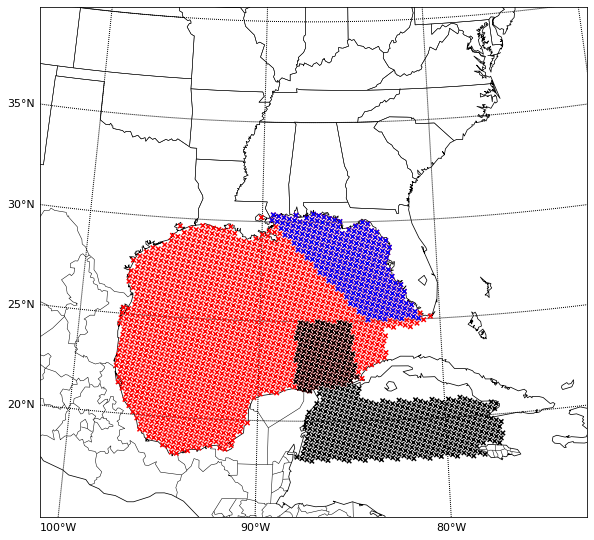

In [16]:
fig = plt.figure(figsize=(8.,11.))

ax = fig.add_axes([0.025, 0.025, 0.95, 0.95])

ax.scatter(x, y, final_filed1.mu_region_scat*20, marker='x', color='k', zorder=4)

ax.scatter(x, y, final_filed1.gom_plume_scat*20, marker='x', color='b', zorder=4)

ax.scatter(x, y, final_filed1.gom_basin_scat*20, marker='x', color='r', zorder=3)

bm.drawcoastlines(linewidth=0.75)
bm.drawstates()
bm.drawcountries()
bm.drawparallels(np.arange(int(20),int(51),5),labels=[1,0,0,0], linewidth=1.0, fontsize=11)
bm.drawmeridians(np.arange(int(-110),int(-65),10),labels=[0,0,0,1], linewidth=1.0, fontsize=11)

plt.show()

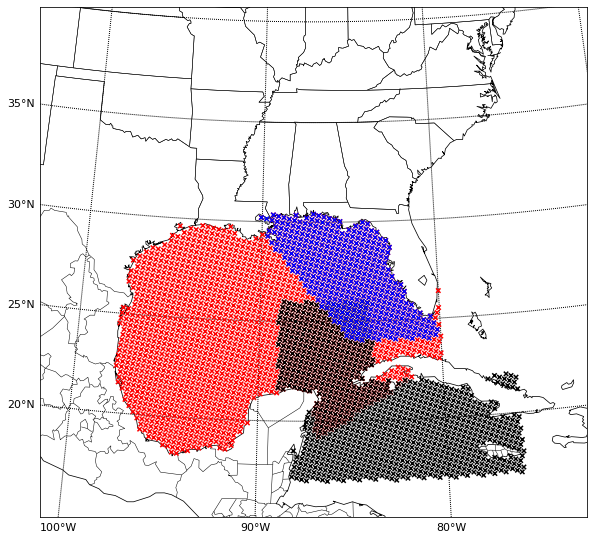

In [17]:
fig = plt.figure(figsize=(8.,11.))

ax = fig.add_axes([0.025, 0.025, 0.95, 0.95])

ax.scatter(x, y, final_filed2.mu_region_scat*20, marker='x', color='k', zorder=4)

ax.scatter(x, y, final_filed2.gom_plume_scat*20, marker='x', color='b', zorder=4)

ax.scatter(x, y, final_filed2.gom_basin_scat*20, marker='x', color='r', zorder=3)

bm.drawcoastlines(linewidth=0.75)
bm.drawstates()
bm.drawcountries()
bm.drawparallels(np.arange(int(20),int(51),5),labels=[1,0,0,0], linewidth=1.0, fontsize=11)
bm.drawmeridians(np.arange(int(-110),int(-65),10),labels=[0,0,0,1], linewidth=1.0, fontsize=11)

plt.show()

In [10]:
#bm.scatter(x, y, file_of_scatters_1*20, marker='x', color='k', zorder=4).properties()

In [18]:
def checker(thefile,index_i,index_j,lats,lons,bm):
    #function for grabbing the edges of the group values
    if thefile[index_i-1,index_j] == 0.0:
        xtemp, ytemp = bm(lons[index_i-1,index_j],lats[index_i-1,index_j])
        if not bm.is_land(xtemp, ytemp):
            return True
    if thefile[index_i,index_j-1] == 0.0:
        xtemp, ytemp = bm(lons[index_i,index_j-1],lats[index_i,index_j-1])
        if not bm.is_land(xtemp, ytemp):
            return True
    if thefile[index_i-1,index_j-1] == 0.0:
        xtemp, ytemp = bm(lons[index_i-1,index_j-1],lats[index_i-1,index_j-1])
        if not bm.is_land(xtemp, ytemp):
            return True
    if thefile[index_i+1,index_j] == 0.0:
        xtemp, ytemp = bm(lons[index_i+1,index_j],lats[index_i+1,index_j])
        if not bm.is_land(xtemp, ytemp):
            return True
    if thefile[index_i,index_j+1] == 0.0:
        xtemp, ytemp = bm(lons[index_i,index_j+1],lats[index_i,index_j+1])
        if not bm.is_land(xtemp, ytemp):
            return True
    if thefile[index_i+1,index_j+1] == 0.0:
        xtemp, ytemp = bm(lons[index_i+1,index_j+1],lats[index_i+1,index_j+1])
        if not bm.is_land(xtemp, ytemp):
            return True
    if thefile[index_i-1,index_j+1] == 0.0:
        xtemp, ytemp = bm(lons[index_i-1,index_j+1],lats[index_i-1,index_j+1])
        if not bm.is_land(xtemp, ytemp):
            return True
    if thefile[index_i+1,index_j-1] == 0.0:
        xtemp, ytemp = bm(lons[index_i+1,index_j-1],lats[index_i+1,index_j-1])
        if not bm.is_land(xtemp, ytemp):
            return True
    else:
        return False

adjacent_scatters_1 = np.zeros((data_skin_lats.shape))
adjacent_scatters_2 = np.zeros((data_skin_lats.shape))
adjacent_scatters_3 = np.zeros((data_skin_lats.shape))
for numer, (i, j) in enumerate(product(range(data_skin_lats[:,0].shape[0]),range(data_skin_lats[0,:].shape[0]))):  
    if final_filed.mu_region_scat[i,j] == 1.0:
        if checker(final_filed.mu_region_scat,i,j,data_skin_lats,data_skin_lons,bm):
            adjacent_scatters_1[i,j] = 1.0
    if final_filed.gom_plume_scat[i,j] == 1.0:
        if checker(final_filed.gom_plume_scat,i,j,data_skin_lats,data_skin_lons,bm):
            adjacent_scatters_2[i,j] = 1.0
    if final_filed.gom_basin_scat[i,j] == 1.0:
        if checker(final_filed.gom_basin_scat,i,j,data_skin_lats,data_skin_lons,bm):
            adjacent_scatters_3[i,j] = 1.0

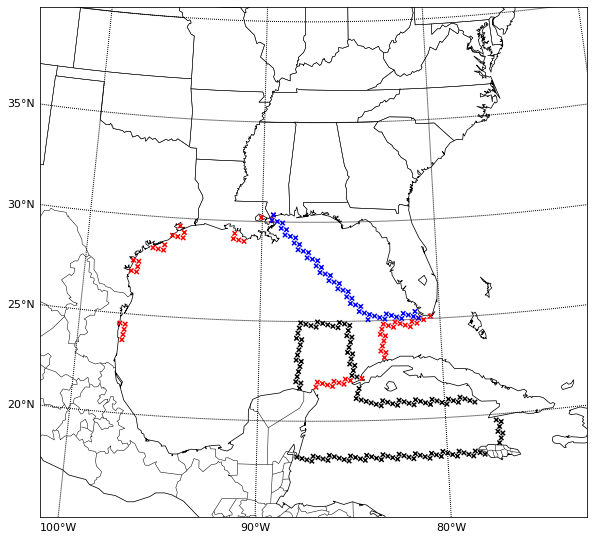

In [19]:
fig = plt.figure(figsize=(8.,11.))

ax = fig.add_axes([0.025, 0.025, 0.95, 0.95])

ax.scatter(x, y, adjacent_scatters_1*20, marker='x', color='k', zorder=4)

ax.scatter(x, y, adjacent_scatters_2*20, marker='x', color='b', zorder=4)

ax.scatter(x, y, adjacent_scatters_3*20, marker='x', color='r', zorder=3)

bm.drawcoastlines(linewidth=0.75)
bm.drawstates()
bm.drawcountries()
bm.drawparallels(np.arange(int(20),int(51),5),labels=[1,0,0,0], linewidth=1.0, fontsize=11)
bm.drawmeridians(np.arange(int(-110),int(-65),10),labels=[0,0,0,1], linewidth=1.0, fontsize=11)

plt.show()

In [20]:
final_filed2 = xr.Dataset({'mu_region_edge':(['x','y'],adjacent_scatters_1),
                           'gom_plume_edge':(['x','y'],adjacent_scatters_2),
                           'gom_basin_edge':(['x','y'],adjacent_scatters_3)},
                           coords={'time':(['time'],pd.to_datetime(data_skin.coords['time'].values)),
                                   'lon':(['x','y'],x),
                                   'lat':(['x','y'],y)},
                           attrs={'File Author':'Maria J. Molina'})

In [21]:
final_filed2

<xarray.Dataset>
Dimensions:         (time: 65, x: 277, y: 349)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-15T09:00:00 ... 2017-01-23T09:00:00
    lon             (x, y) float64 -5.291e+06 -5.265e+06 ... 7.656e+06 7.681e+06
    lat             (x, y) float64 4.328e+03 5.324e+03 ... 5.657e+06 5.635e+06
Dimensions without coordinates: x, y
Data variables:
    mu_region_edge  (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    gom_plume_edge  (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    gom_basin_edge  (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    File Author:  Maria J. Molina

In [22]:
final_filed2.to_netcdf('/glade/work/molina/DATA/jan2017_synoptic/perturb_skin_edge.nc')

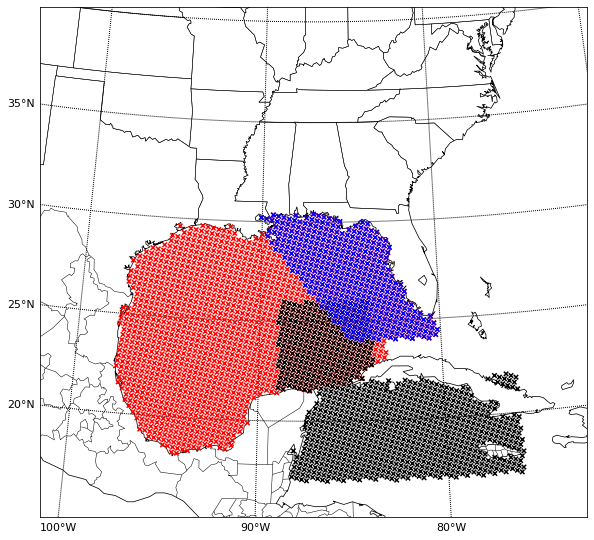

In [13]:
fig = plt.figure(figsize=(8.,11.))

ax = fig.add_axes([0.025, 0.025, 0.95, 0.95])

ax.scatter(x, y, final_filed.mu_region_scat*20, marker='x', color='k', zorder=4)

ax.scatter(x, y, final_filed.gom_plume_scat*20, marker='x', color='b', zorder=4)

ax.scatter(x, y, final_filed.gom_basin_scat*20, marker='x', color='r', zorder=3)

bm.drawcoastlines(linewidth=0.75)
bm.drawstates()
bm.drawcountries()
bm.drawparallels(np.arange(int(20),int(51),5),labels=[1,0,0,0], linewidth=1.0, fontsize=11)
bm.drawmeridians(np.arange(int(-110),int(-65),10),labels=[0,0,0,1], linewidth=1.0, fontsize=11)

plt.show()